In [1]:
import pandas as pd
import numpy as np
import re
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from itertools import product
from scipy import stats

%matplotlib inline
plt.style.use('ggplot')
#plt.style.use('seaborn-pastel')
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tq

import matplotlib as mpl
font = {"family":"osaka"}
mpl.rc('font', **font)

sys.path.append("..")
from utils.util_functions import *

pd.set_option('display.max_rows', 500)

In [2]:
#event_df = make_df(data_dir=DETAIL_DATA_DIR_MLB)
#event_df = pd.read_csv(os.path.join(ROOT_DIR, "event_df.csv"), index_col=0, encoding="cp932", dtype=object)
#df_2017 = make_df(end=1944417, data_dir=DETAIL_DATA_DIR_MLB)
#df_2017 = pd.read_csv(os.path.join(ROOT_DIR, "df_2017.csv"), index_col=0, encoding="cp932", dtype=object)
#df_2018 = make_df(start=1944417, data_dir=DETAIL_DATA_DIR_MLB)
#df_2018 = pd.read_csv(os.path.join(ROOT_DIR, "df_2018.csv"), index_col=0, encoding="cp932", dtype=object)
files = os.listdir(DETAIL_DATA_DIR_MLB)[1:]
names = pd.Series(files).apply(lambda x: int(x.split(".")[0]))
files_2017 = names[names<=1944417].apply(lambda x: str(x)+".csv")
files_2018 = names[names>1944417].apply(lambda x: str(x)+".csv")
column = "得点"
teams_mlb = list(set(pd.read_csv(os.path.join(SCORE_DATA_DIR_MLB, "score_mlb.csv"), encoding="cp932", index_col=0).表チーム))
teams_mlb.remove("ア・リーグ")
first_teams = ['Rソックス', 'インディアンス', 'アストロズ', 'ブレーブス', 'ブリュワーズ', 'ドジャース']
second_teams = ['ヤンキース', 'ツインズ', 'アスレチックス', 'ナショナルズ', 'カブス', 'ロッキーズ']
third_teams = ['レイズ', 'タイガース', 'マリナーズ', 'フィリーズ', 'カージナルス', 'Dバックス']
fourth_teams = ['ブルージェイズ', 'Wソックス',  'エンゼルス', 'メッツ', 'パイレーツ', 'ジャイアンツ']
fifth_teams = ['オリオールズ', 'ロイヤルズ', 'レンジャーズ', 'マーリンズ', 'レッズ', 'パドレス']

In [5]:
team = "Rソックス"

In [6]:
lst = make_flattened_list(make_inning_triple(make_inning_list(event_df[event_df.攻撃チーム==team])))

In [18]:
det_lst = [elem[1][1:] for elem in lst if is_deteriorated(elem[0], elem[1])]
imp_lst = [elem[1][1:] for elem in lst if is_improved(elem[0], elem[1])]

In [19]:
stats.ks_2samp(imp_lst, det_lst).statistic

0.61538469439632004

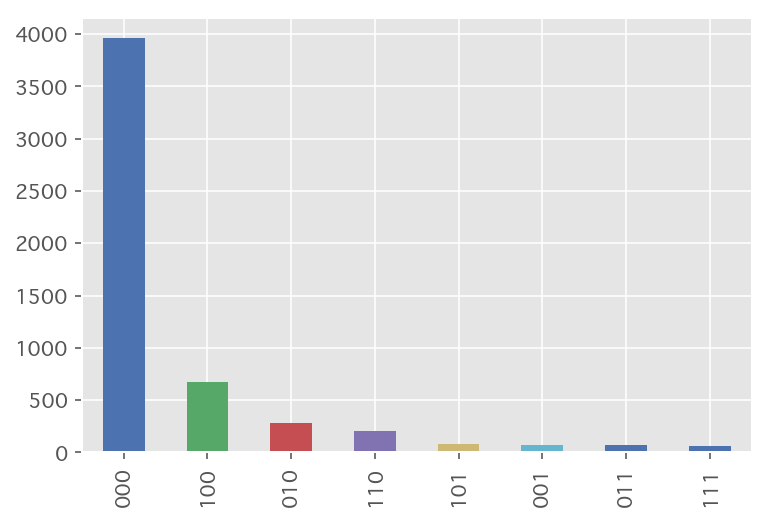

In [25]:
pd.Series(det_lst).value_counts().plot(kind="bar")

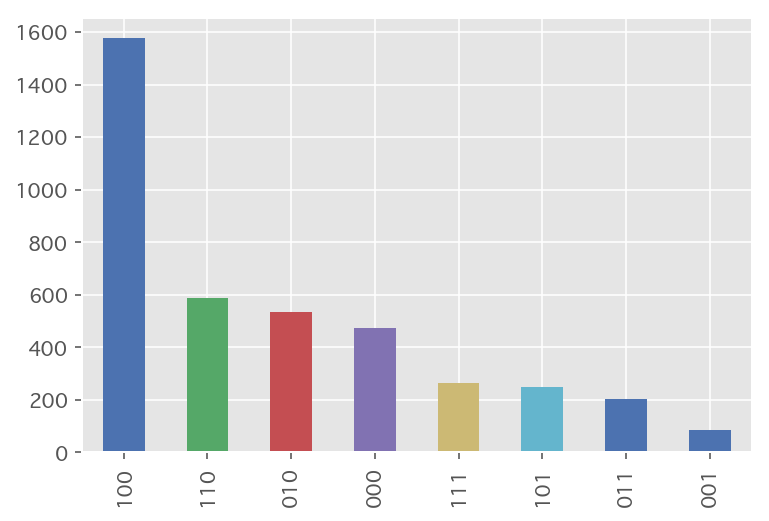

In [26]:
pd.Series(imp_lst).value_counts().plot(kind="bar")

In [ ]:
def pos_neg(team, nlead=5, nbehind=4, year="both"):
    if year == "both":
        df = event_df[event_df.攻撃チーム==team]
    elif year == 2018:
        df = df_2018[df_2018.攻撃チーム==team]
    elif year == 2017:
        df = df_2017[df_2017.攻撃チーム==team]
        
    # 点差関係なし
    triple = make_inning_triple(make_inning_list(df, score_end=1, how="own"))
    lst = make_flattened_list(triple[:])
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    all_imp, all_det = np.mean(improved_score_list), np.mean(deteriorated_score_list)
    
    #  nlead点差以上リード
    lst = triple_on_score_diff(team, nlead, 30, year)
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    pos_imp, pos_det = np.mean(improved_score_list), np.mean(deteriorated_score_list)
    
    # nbehind点差以上ビハインド
    lst = triple_on_score_diff(team, -nbehind, -1, year)
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    neg_imp, neg_det = np.mean(improved_score_list), np.mean(deteriorated_score_list)
    
    return [team, all_imp, all_det, pos_imp, pos_det, neg_imp, neg_det]

In [ ]:
#pos_neg("インディアンス", year=2017)

In [ ]:
res = []
for team in teams_mlb:
    curr = pos_neg(team, year=2018)
    curr[0] = curr[0] + "2018"
    res.append(curr)
    print(curr[0])
    curr = pos_neg(team, year=2017)
    curr[0] = curr[0] + "2017"
    res.append(curr)
    print(curr[0])

In [ ]:
df = pd.DataFrame(res, columns=["チーム", "all_imp", "all_det", "pos_imp", "pos_det", "neg_imp", "neg_det"]).set_index("チーム", drop=True)

In [ ]:
df["positive_inhibition"] = - df["pos_imp"] + df["all_imp"]
df["negative_facilitation"] = df["neg_det"] - df["all_det"]

In [ ]:
df[["positive_inhibition", "negative_facilitation"]]
plt.scatter(df["positive_inhibition"], df["negative_facilitation"])

In [ ]:
df

In [ ]:
plt.figure(figsize=(12, 6))
colors = ["r", "b", "y", "g", "c"]
for team in df.index:
    pos_inh = df.loc[team, "positive_inhibition"]
    neg_fac = df.loc[team, "negative_facilitation"]
    plt.scatter([pos_inh], [neg_fac], marker="${}$".format(ranking(team[:-4], int(team[-4:]))), color=colors[ranking(team[:-4], int(team[-4:]))-1], s=200)
plt.xlabel("positive_inhibition (5点差以上のリード)")
plt.ylabel("negative_facilitation (4点差以内のビハインド)")

In [ ]:
pd.DataFrame([list(order_pos_dict.values()), list(order_neg_dict.values())], index=["positive_inhibition", "negative_facilitation"], columns=[1, 2, 3, 4, 5]).T.plot()

In [ ]:
order_pos_dict = defaultdict(int)
for teamyear in df.index:
    team = teamyear[:-4]
    year = int(teamyear[-4:])
    order_pos_dict[ranking(team, year)] += df.loc[teamyear, "positive_inhibition"]

In [ ]:
order_pos_dict

In [ ]:
order_neg_dict = defaultdict(int)
for teamyear in df.index:
    team = teamyear[:-4]
    year = int(teamyear[-4:])
    order_neg_dict[ranking(team, year)] += df.loc[teamyear, "negative_facilitation"]

In [ ]:
order_neg_dict

In [ ]:
df.loc[:, "positive_inhibition"].hist()

In [ ]:
df.loc[:, "negative_facilitation"].hist()